In [1]:
import keras
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf
!pip install tensorflow==1.14.0

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [87]:
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()


In [88]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))


In [89]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 8)                 112       
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 9         
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [90]:
from keras import backend as K
func = K.function([model.layers[0].input], [model.layers[-2].output])

In [91]:
model.layers[-2].output

<tf.Tensor 'dropout_4/cond/Merge:0' shape=(?, 8) dtype=float32>

In [92]:
lrs = []
K1 = 0.
K2 = 0.
beta1 = 0.9
beta2 = 0.999
batch_size=32
num_classes=2
from tqdm import tqdm

In [93]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    global K1, K2

    Kz = 0.
    S = 0.
    
    sess = tf.compat.v1.keras.backend.get_session()
    max_wt = 0.
    for weight in model.weights:
        norm = np.linalg.norm(weight.eval(sess))
        if norm > max_wt:
            max_wt = norm
    
    for i in range((len(x_train) - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
    	
        tmp = np.array(func([xb]))
        activ = np.linalg.norm(tmp)
        sq = np.linalg.norm(np.square(tmp))

        if sq > S:
            S = sq
        
        if activ > Kz:
            Kz = activ

    K_ = ((num_classes - 1) * Kz) / (num_classes * batch_size)
    S_ = (num_classes - 1) ** 2 / (num_classes * batch_size) ** 2 * S 
    
    K1 = beta1 * K1 + (1 - beta1) * K_
    K2 = beta2 * K2 + (1 - beta2) * S_

    lr = (np.sqrt(K2) + K.epsilon()) / K1
    print('S =', S, ', K1 =', K1,', K2 =', K2, ', K_ =', K_, ', lr =', lr)
    lrs.append(lr)
    print('Epoch', epoch, 'LR =', lr)
    return lr


In [94]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [95]:
from keras.optimizers import Adam
optimizer = Adam(lr=1e-3, decay=1e-4)
model.compile(loss='mse', optimizer=optimizer, metrics=["mae"])

In [96]:
history=model.fit(x_train, y_train, epochs = 35, batch_size = 16,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

Train on 404 samples, validate on 102 samples
Epoch 1/35
S = 85155.375 , K1 = 1.5108464241027828 , K2 = 0.020789886474609394 , K_ = 15.108464241027832 , lr = 0.09543463989090821
Epoch 0 LR = 0.09543463989090821
404/404 [==============================] - 1s 1ms/step - loss: 810.8415 - mae: 16.3742 - val_loss: 229.8712 - val_mae: 12.5344
Epoch 2/35
S = 10610.323 , K1 = 1.7333661508560176 , K2 = 0.02335950753593447 , K_ = 3.736043691635132 , lr = 0.08817425808486398
Epoch 1 LR = 0.08817425808486398
404/404 [==============================] - 0s 129us/step - loss: 201.0235 - mae: 10.8260 - val_loss: 127.4841 - val_mae: 8.5867
Epoch 3/35
S = 29303.012 , K1 = 2.181796198368072 , K2 = 0.03049020362379649 , K_ = 6.2176666259765625 , lr = 0.08003247182315881
Epoch 2 LR = 0.08003247182315881
404/404 [==============================] - 0s 121us/step - loss: 167.6549 - mae: 9.6970 - val_loss: 162.7323 - val_mae: 10.2306
Epoch 4/35
S = 22956.938 , K1 = 2.502047460031509 , K2 = 0.036064434489508634 , 

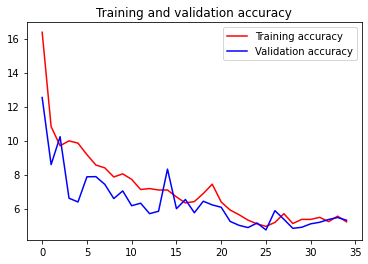

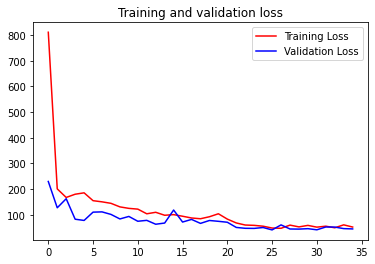

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.savefig('acc.png')

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [99]:
print(min(acc),max(acc))

4.953653 16.374199
